**МЕТАНПРОМБАНК 2**

Презентация по ссылке:
https://disk.yandex.ru/i/ID9XPoscF5Guow

Проект выполнила: Лисина Татьяна Александровна  
Дата: 15.03.2023  
Контактные данные: +37444433077 , Whatsapp https://wa.me/79645059655, Telegram https://t.me/bestearthman, почта bestearthman@yandex.ru

**ЗАДАЧА ПРОЕКТА:**  
Проанализировать отток клиентов Метанпромбанка - найти зависимости между ушедшими клиентами и их параметрами.  
Дать рекомендации в виде портрета клиента, находящегося в зоне риска.

**Ход исследования:**  
- Знакомство с данными: общая информация и гистограммы с описанием данных
- Предобработка данных: проверка соответствия содержания, удаление дубликатов, аномалий, создание рабочих столбцов
- Анализ данных: составление единой таблицы корреляции, выделение рисковых сегментов в каждом параметре клиента, выводы
- Объединение рисковых сегменов по 2-4 параметрам, проверка усиления ухода
- Проверка гипотез - зарплаты и уход, продукты и уход.
- Выводы

### ОБЩАЯ ИНФОРМАЦИЯ

In [89]:
!pip install phik

Defaulting to user installation because normal site-packages is not writeable


In [90]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats as stats
from scipy import stats as st
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import math

import phik
from phik.report import plot_correlation_matrix
from phik import report

import warnings
warnings.filterwarnings("ignore")

In [91]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F')
df

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


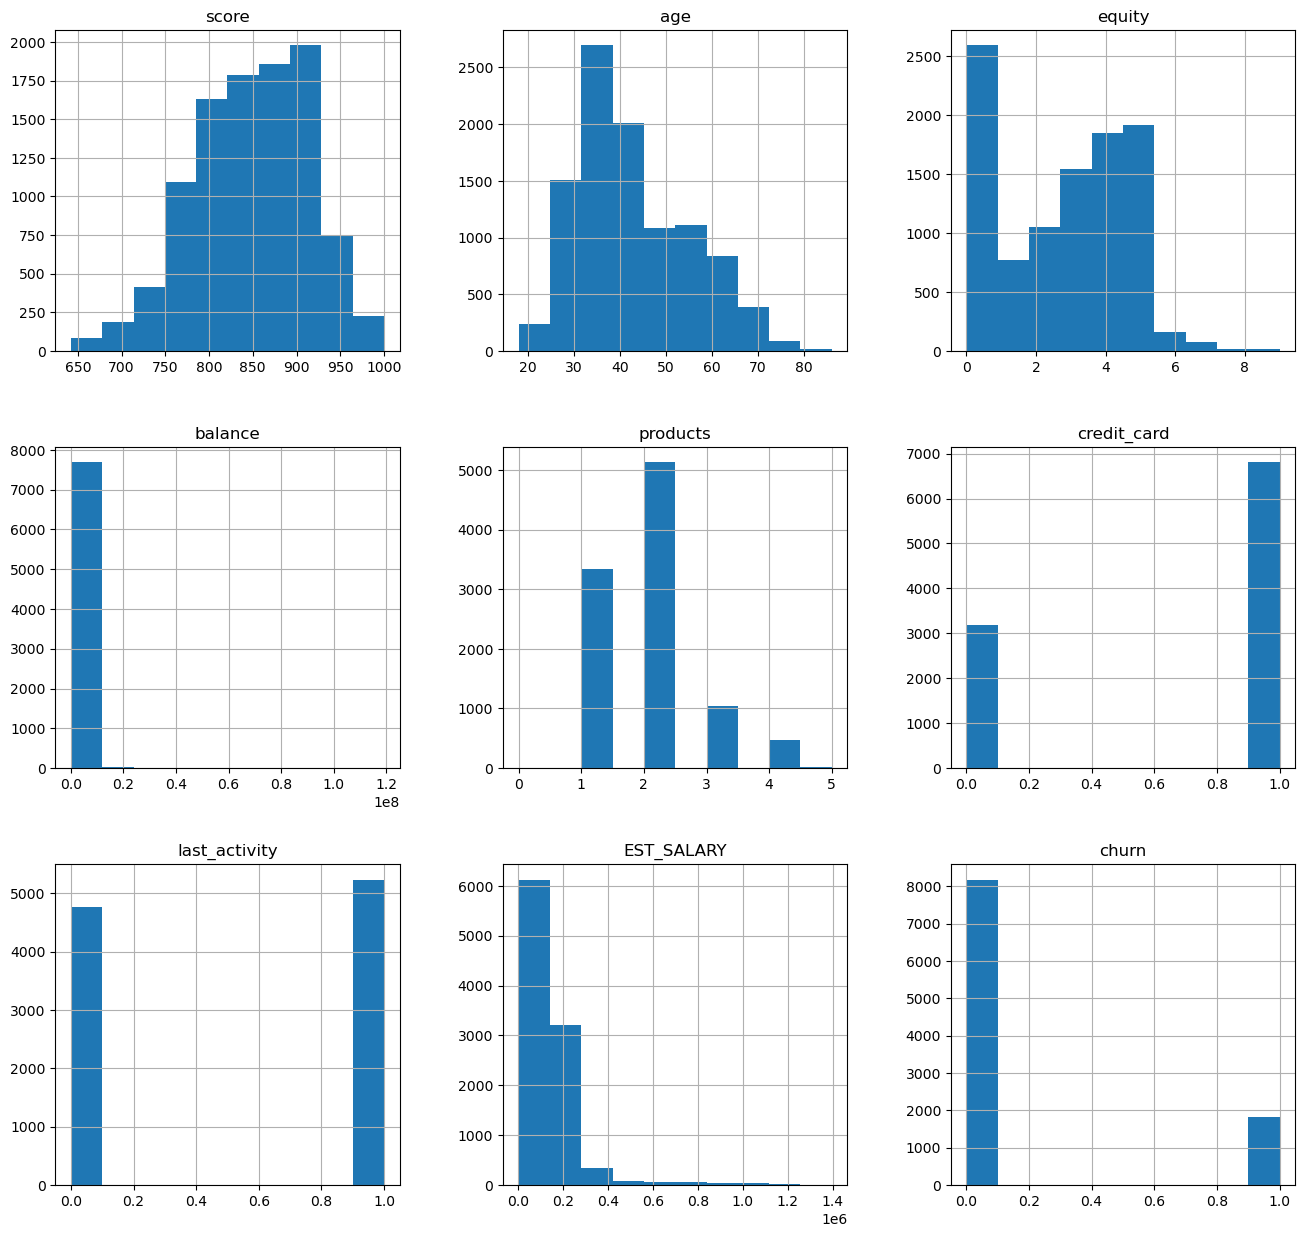

In [93]:
df[['score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'EST_SALARY', 'churn']].hist(figsize=(16, 15));

In [94]:
df['balance'].describe().round()

count         7705.0
mean        827794.0
std        1980614.0
min              0.0
25%         295554.0
50%         524272.0
75%         980706.0
max      119113552.0
Name: balance, dtype: float64

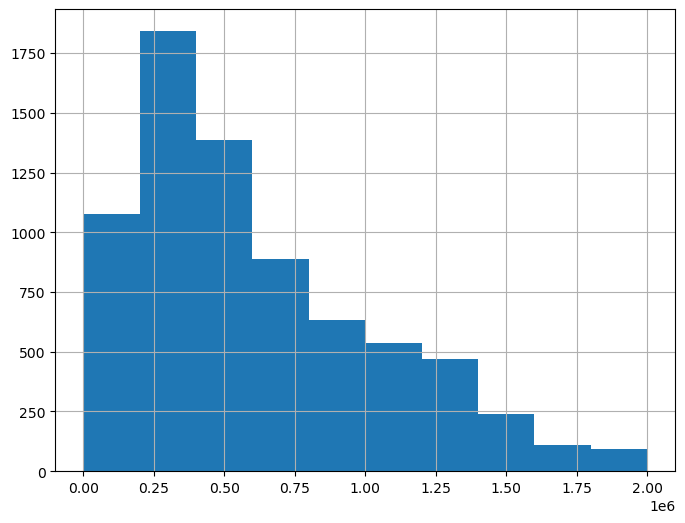

In [95]:
df['balance'].hist(range=(0, 2000000), figsize=(8, 6));

На гистаграммах по необработанным данным видим:  
- Скоринг большинства клиентов 800-900 баллов (кредитоспособные клиенты)
- Наиболее популярный возраст 30-40 лет
- Много клиентов с рейтингом оценки собственности 4-5 баллов, но также много с рейтингом 0 (стоит рассмотреть)
- Баланс большинства клиентов 200 000 - 500 000 р.
- Чаще всего у клиента два продукта
- Примерно 70% клиентов имеют кредитную карту
- Количество активных и пассивных клиентов почти одинаковое 
- Предполагаемая зарплата, как правило, не больше 200 000 р.
- Ушедших клиентов около 20% от общего числа

### ПРЕДОБРАБОТКА ДАННЫХ

#### Оформление

Приведём название колонок к удобному формату

In [96]:
df.columns = df.columns.str.lower()

In [97]:
df = df.rename(columns={'userid' : 'id'})

#### Дубликаты

Найдём и удалим явные дубликаты:

In [98]:
df.duplicated().sum()

0

In [99]:
df = df.drop_duplicates()

Проверим неявные дубликаты:

In [100]:
dubl_id = pd.concat(g for _, g in df.groupby('id') if len(g) > 1)
dubl_id

,id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4216,226719,903.0,Рыбинск,Ж,63.0,0,NaN,1,1,0,138582.58,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0


In [101]:
dubl_id['id'].nunique()

73

In [102]:
dubl_id_percent = round((dubl_id.shape[0]/df.shape[0]*100), 1)
dubl_id_percent

1.5

In [103]:
print('Есть повторяющиеся клиенты, это похоже на ошибку. Поскольку дублирующихся строк не более', dubl_id_percent,'% - удалим их.')

Есть повторяющиеся клиенты, это похоже на ошибку. Поскольку дублирующихся строк не более 1.5 % - удалим их.


In [104]:
df = df.loc[~df['id'].isin(list(dubl_id['id']))]

#### Пропуски

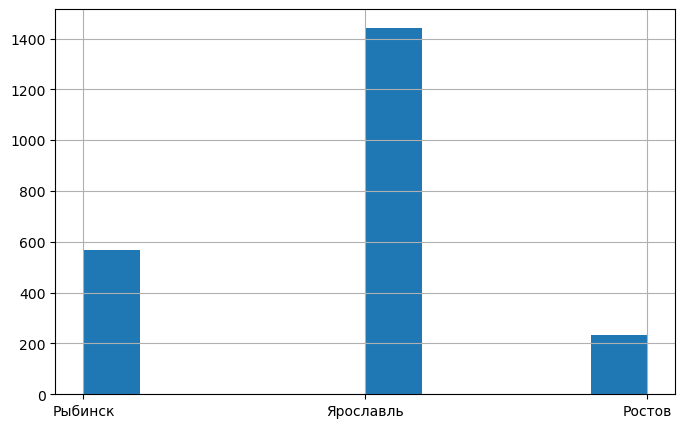

In [105]:
df_balance_isna = df.loc[df['balance'].isna()]
df_balance_isna['city'].hist(figsize=(8, 5));

Данные собраны полностью кроме одного столбца - **balance**. Эти данные нам неоткуда взять, поэтому в расчетах, связанных с балансом на счете, будем использовать только заполненные строки. (Пропуски распределены по городам равномерно в соответствии с долей клиентов)

#### Аномалии

Проверим корректность заполения данных по столбцам

In [106]:
df['city'].value_counts()

Ярославль    5815
Рыбинск      2622
Ростов       1417
Name: city, dtype: int64

Больше всего клиентов из Ярославля.

In [107]:
df['gender'].value_counts()

М    4929
Ж    4925
Name: gender, dtype: int64

Среди клиентов банка почти одинаковое количество мужчин и женщин.

In [108]:
df['products'].value_counts()

2    5070
1    3287
3    1021
4     457
5      18
0       1
Name: products, dtype: int64

Всего один человек не имеет продуктов в банке, удалим его для удобства графиков

In [109]:
df = df.query('products > 0')

Все остальное корректно. Данные в других столбцах мы оценили по гистограммам.

In [110]:
df = df.reset_index(drop=True)

#### Новые столбцы

Добавим новый столбец пола с числовыми данными:

In [111]:
df['gender2'] = df['gender']
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df = df.rename(columns={'gender2' : 'gender', 'gender_М' : 'gender_m'})
df.head()

,id,score,city,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender,gender_m
0,183012,850.0,Рыбинск,25.0,1,59214.82,2,0,1,75719.14,1,Ж,0
1,146556,861.0,Рыбинск,37.0,5,850594.33,3,1,0,86621.77,0,Ж,0
2,120722,892.0,Рыбинск,30.0,0,NaN,1,1,1,107683.34,0,Ж,0
3,225363,866.0,Ярославль,51.0,5,1524746.26,2,0,1,174423.53,1,Ж,0
4,157978,730.0,Ярославль,34.0,5,174.00,1,1,0,67353.16,1,М,1


Добавим новый столбец города для таблицы корреляции:

In [112]:
def city(a):
    if a == 'Ярославль':
        return 1
    if a == 'Ростов':
        return 2
    if a == 'Рыбинск':
        return 3

In [113]:
df['city_c'] = df['city'].apply(city)

### АНАЛИЗ ДАННЫХ

#### Единая таблица корреляции

Посмотрим, есть ли зависимость между данными по каждому столбцу:

In [114]:
# переменная с названиями столбцов
columns = list(df.columns)
columns = columns[2:]

In [115]:
df_corr = df[columns]

In [172]:
rs = np.random.RandomState(0)
c = pd.DataFrame(rs.rand(11,11))
corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_m,city_c
age,1.000000,0.021612,0.070836,0.020152,-0.123094,-0.007954,-0.039632,-0.047498,-0.212388,0.047084
equity,0.021612,1.000000,0.163061,0.431298,-0.166584,-0.003292,-0.173374,0.266401,-0.021358,0.011473
balance,0.070836,0.163061,1.000000,0.075323,-0.058787,0.025158,0.332970,0.083981,0.051141,-0.048768
products,0.020152,0.431298,0.075323,1.000000,-0.254978,0.035846,-0.118153,0.298130,-0.022567,-0.047190
credit_card,-0.123094,-0.166584,-0.058787,-0.254978,1.000000,-0.033665,0.038024,-0.129083,0.128105,-0.091109
last_activity,-0.007954,-0.003292,0.025158,0.035846,-0.033665,1.000000,0.002039,0.166841,-0.013127,0.052093
est_salary,-0.039632,-0.173374,0.332970,-0.118153,0.038024,0.002039,1.000000,-0.001014,0.082282,-0.099727
churn,-0.047498,0.266401,0.083981,0.298130,-0.129083,0.166841,-0.001014,1.000000,0.141766,-0.030375
gender_m,-0.212388,-0.021358,0.051141,-0.022567,0.128105,-0.013127,0.082282,0.141766,1.000000,-0.019250
city_c,0.047084,0.011473,-0.048768,-0.047190,-0.091109,0.052093,-0.099727,-0.030375,-0.019250,1.000000


Сильных зависимостей нет. Есть слабые зависимости между количеством продуктов и собственностью, доходом  и балансом на счёте, уходом клиента и собственностью / количеством продуктов. В первую очередь нас интересуют последние две зависимости, влияющие на уход.

Подготовим таблицу для корреляции Фик оставив только нужные стобцы:

In [117]:
columns2 = ['score', 'city', 'age', 'equity', 'balance', 'products',
       'credit_card', 'last_activity', 'est_salary', 'churn', 'gender']
df_phik = df[columns2]

In [118]:
phik_overview = df_phik.phik_matrix().round(2)
phik_overview.round(2)

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn']


,score,city,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender
score,1.00,0.09,0.04,0.53,0.16,0.42,0.21,0.06,0.39,0.22,0.07
city,0.09,1.00,0.09,0.06,0.04,0.13,0.08,0.03,0.17,0.02,0.01
age,0.04,0.09,1.00,0.04,0.02,0.14,0.16,0.09,0.36,0.18,0.29
equity,0.53,0.06,0.04,1.00,0.00,0.58,0.22,0.05,0.29,0.35,0.07
balance,0.16,0.04,0.02,0.00,1.00,0.00,0.00,0.00,0.37,0.02,0.04
products,0.42,0.13,0.14,0.58,0.00,1.00,0.27,0.11,0.22,0.26,0.07
credit_card,0.21,0.08,0.16,0.22,0.00,0.27,1.00,0.05,0.04,0.20,0.20
last_activity,0.06,0.03,0.09,0.05,0.00,0.11,0.05,1.00,0.04,0.26,0.01
est_salary,0.39,0.17,0.36,0.29,0.37,0.22,0.04,0.04,1.00,0.04,0.14
churn,0.22,0.02,0.18,0.35,0.02,0.26,0.20,0.26,0.04,1.00,0.22


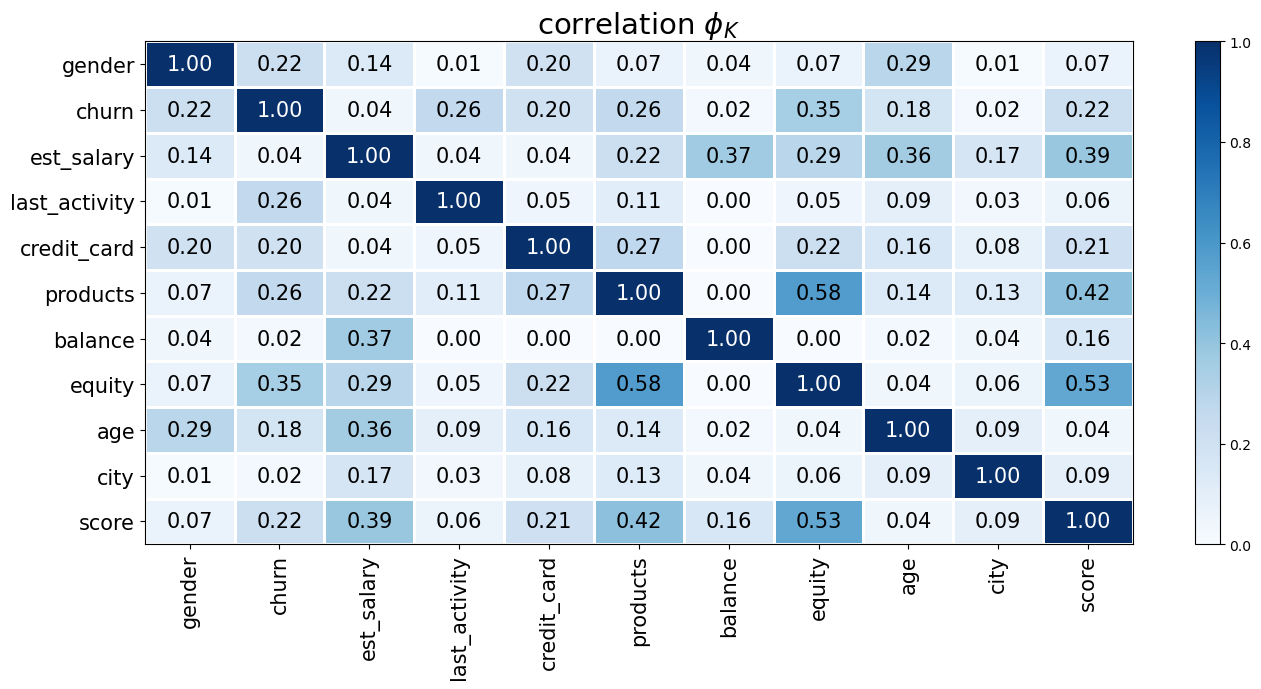

In [119]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(14, 7))
plt.tight_layout()

По таблице корреляции Фик видим высокую и среднюю зависимость между тремя параметрами - **продуктами, собственностью и скорингом**.


Умеренные между **зарплатой и скорингом / возрастом / балансом, между уходом и собственностью, между возрастом и полом**.  

Слабые зависимости между зарплатой и собственностью / продуктами, между кредитными картами и продуктами / собственностью / скорингом, между уходом и активностью / продуктами / скорингом / кредитными картами.

Разделим клиентов на сегменты внутри параметров (возраст, город т.д) и проверим, различается ли корреляция среди них.

#### Проверка корреляции внутри сегментов

Проверим все параметры клиентов по очереди, для этого создадим две функции:  
- **pivot_table** - создает сводную таблицу для графика
- **histogram** - строит график по ней
- **histogram_bins** - строит график с указанием корзин bins

In [120]:
def pivot_table(dataframe, column_name):
    global pivot_table_df 
    pivot_table_df = (dataframe.pivot_table(index=['churn', column_name], values='id', aggfunc='count')
                     .reset_index().sort_values(by='id', ascending=False))
    pivot_table_df = pivot_table_df.rename(columns={'id' : 'count'})
    #return pivot_table_df

In [121]:
def histogram(pivot_table_df, column, x, y1, y2, title1, title2):
    fig = make_subplots(rows=1, cols=2)
    
    fig1 = px.histogram(pivot_table_df, x=column,
                       y='count', color='churn',
                       #barnorm='percent', #text_auto='.2f',
                       title=title1,
                       labels={'churn':'Уход'},
                       color_discrete_sequence=['#8faae2','#003d7d'])
    fig1.update_layout(xaxis_title = x,
                      yaxis_title = y1,
                      width=600, height=500,)
    fig1.update_layout(xaxis={'categoryorder':'total descending'})


    fig2 = px.histogram(pivot_table_df, x=column,
                       y='count', color='churn',
                       barnorm='percent', #text_auto='.2f',
                       title=(title2),
                       labels={'churn':'Уход'},
                       color_discrete_sequence=['#8faae2','#003d7d'],)
    fig2.update_layout(xaxis_title = x,
                      yaxis_title = y2,
                      width=600, height=500)
    fig2.update_layout(xaxis={'categoryorder':'total descending'})

    fig1.show()
    fig2.show()   

In [122]:
def histogram_bins(pivot_table_df, column, x, y1, y2, bins, title1, title2):
    fig = make_subplots(rows=1, cols=2)
    
    fig1 = px.histogram(pivot_table_df, nbins=bins, x=column,
                       y='count', color='churn',
                       #barnorm='percent', #text_auto='.2f',
                       title=title1,
                       labels={'churn':'Уход'},
                       color_discrete_sequence=['#8faae2','#003d7d'],)
    fig1.update_layout(xaxis_title = x,
                      yaxis_title = y1,
                      width=600, height=500,)
    fig1.update_layout(xaxis={'categoryorder':'total descending'})


    fig2 = px.histogram(pivot_table_df, nbins=bins, x=column,
                       y='count', color='churn',
                       barnorm='percent', #text_auto='.2f',
                       title=(title2),
                       labels={'churn':'Уход'},
                       color_discrete_sequence=['#8faae2','#003d7d'],)
    fig2.update_layout(xaxis_title = x,
                      yaxis_title = y2,
                      width=600, height=500)
    fig2.update_layout(xaxis={'categoryorder':'total descending'})

    fig1.show()
    fig2.show()   

##### Сегментирование по возрасту

Разделим всех клиентов на 4 возрастные категории: 18-30, 30-45, 45-60 и больше 60 лет.

In [123]:
def age(a):
    if a <= 30:
        return '18-30'
    if a <=45:
        return '30-45'
    if a <=60:
        return '45-60'
    return '>60'

In [124]:
df['age_c'] = df['age'].apply(age)
df.head()

,id,score,city,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender,gender_m,city_c,age_c
0,183012,850.0,Рыбинск,25.0,1,59214.82,2,0,1,75719.14,1,Ж,0,3,18-30
1,146556,861.0,Рыбинск,37.0,5,850594.33,3,1,0,86621.77,0,Ж,0,3,30-45
2,120722,892.0,Рыбинск,30.0,0,NaN,1,1,1,107683.34,0,Ж,0,3,18-30
3,225363,866.0,Ярославль,51.0,5,1524746.26,2,0,1,174423.53,1,Ж,0,1,45-60
4,157978,730.0,Ярославль,34.0,5,174.00,1,1,0,67353.16,1,М,1,1,30-45


In [125]:
df['age_c'].value_counts()

30-45    4953
45-60    2472
18-30    1404
>60      1024
Name: age_c, dtype: int64

In [126]:
pivot_table(df, df['age_c'])

In [127]:
histogram(pivot_table_df, pivot_table_df['age_c'], 'Возраст', 'Количество', 'Доля %', 
          'Ушедшие и оставшиеся клиенты по возрастным категориям <br>(абсолютное)', 
          'Ушедшие и оставшиеся клиенты по возрастным категориям <br>(относительное)')

**Для проверки построим гистограмму с разбивкой по 10 лет:**

- Самые стабильные клиенты в возрасте **старше 60 лет - уход всего 2%**. Но среди клиентов банка их малая часть (не более 5%).  
- Среди остальных возрастных категорий соотношение похожее - уход от 17 до 22 %. **Категория 18-30 самая нестабильная.**

In [128]:
pivot_table(df, df['age'])

In [129]:
histogram(pivot_table_df, pivot_table_df['age'], 'Возраст', 'Количество', 'Доля %', 
          'Ушедшие и оставшиеся клиенты по возрастным категориям <br>(абсолютное)', 
          'Ушедшие и оставшиеся клиенты по возрастным категориям <br>(относительное)')

**Уточняем выводы:**
- Самые нестабильные возрастные категории **50-60 лет и 20-30 лет**  
- Самые стабильные клиенты **старше 60 лет**
- Клиентов младше 20 лет или старше 80 настолько мало, что на них можно не ориентироваться

Далее для большей точности будем строить гистограммы с большим количеством сегментов, либо в соответствии с категориями параметра.

##### Сегментирование по городам

Разделим всех клиентов по городам: 

In [130]:
pivot_table(df, df['city'])

In [131]:
histogram(pivot_table_df, pivot_table_df['city'], 'Город', 'Количество', 'Доля %', 
          'Ушедшие и оставшиеся клиенты по городам <br>(абсолютное)', 
          'Ушедшие и оставшиеся клиенты по городам <br>(относительное)')

В Ростове и Ярославле процент ухода клиентов одинаковый - 18,7%. **В рыбинске на 3% ниже уход** - 15,8%.  
Нельзя сходу сказать, является ли эта разница статистически значимой.

##### Сегментирование по скорингу

In [132]:
pivot_table(df, df['score'])

In [133]:
histogram(pivot_table_df, pivot_table_df['score'], 'Баллы скоринга', 'Количество', 'Доля %', 
          'Баллы скоринга ушедших и оставшихся клиентов <br>(абсолютное)', 
          'Баллы скоринга ушедших и оставшихся клиентов <br>(относительное)')

Чем ближе скоринг к **870 баллам**, тем выше **риск ухода клиента - до 30%!**  
Это довольно явная и интересная закономерность. Её стоит учитывать. Определим сегмент клиентов в зоне риска с 820-940 баллами скоринга.

##### Сегментирование по полу

In [134]:
pivot_table(df, df['gender'])

In [135]:
histogram(pivot_table_df, pivot_table_df['gender'], 'Пол', 'Количество', 'Доля %', 
          'Сегментирование по полу (абсолютное)', 
          'Сегментирование по полу (относительное)')

Процент ушедших мужчин **в два раза выше**, чем женщин (23% и 12% соответственно).

##### Сегментирование по оценке собственности

In [136]:
pivot_table(df, df['equity'])

In [137]:
histogram_bins(pivot_table_df, pivot_table_df['equity'], 'Оценка собственности', 'Количество', 'Доля %', 10,
              'Сегментирование по оценке собственности (абсолютное)', 
              'Сегментирование по оценке собственности (относительное)')

Интересная зависимость - чем выше у клиента оценка собственности, тем больше риск ухода.   
Клиентов, имеющих оценку собственности выше 5 баллов очень мало, риск ухода среди них 34-54%.  
Отметим клинтов в зоне риска с **оценкой собственности от 4 баллов (25% ухода)**.

##### Сегментирование по балансу

Для анализа баланса исключим выбросы по верхней границе - до 2 млн на счёте (95%). 

In [138]:
df_balance_norm = df.query('balance <= 2000000')

In [139]:
pivot_table(df_balance_norm, df_balance_norm['balance'])

In [140]:
histogram_bins(pivot_table_df, pivot_table_df['balance'], 'Баланс на счёте', 'Количество', 'Доля %', 10,
              'Сегментирование по балансу на счёте (абсолютное)', 
              'Сегментирование по балансу на счёте (относительное)')

Есть зависимость - **чем больше баланс, тем выше процент ухода клиента** (от 15% до 34%).  
Клиентов с балансом выше 1,5 млн слишком мало, чтобы учитывать их статистику.  
Будем считать клиентов в зоне риска с балансом более 700 000 р. (уход 24%)

##### Сегментирование по количеству продуктов

In [141]:
df['products'].value_counts()

2    5070
1    3287
3    1021
4     457
5      18
Name: products, dtype: int64

In [142]:
pivot_table(df, df['products'])

In [143]:
histogram_bins(pivot_table_df, pivot_table_df['products'], 'Количество продуктов', 'Количество', 'Доля %', 5,
              'Сегментирование по количеству продуктов (абсолютное)', 
              'Сегментирование по количеству продуктов (относительное)')

Также есть возрастающая зависимость - **чем больше продуктов, тем выше риск ухода клиента** (от 7% до 63%).  
Клиентов с 5 продуктами не рассматриваем, слишком маленькая выборка.

##### Сегментирование по наличию кредитной карты

In [144]:
pivot_table(df, df['credit_card'])

In [145]:
histogram_bins(pivot_table_df, pivot_table_df['credit_card'], 'Наличие кредитной карты', 'Количество', 'Доля %', 2,
              'Сегментирование по наличию кредитной карты (абсолютное)', 
              'Сегментирование по наличию кредитной карты (относительное)')

Клиенты без кредитной карты покидают банк **в 1,5 раза чаще**.

##### Сегментирование по активности клиента

In [146]:
pivot_table(df, df['last_activity'])

In [147]:
histogram_bins(pivot_table_df, pivot_table_df['last_activity'], 'Активность клиента', 'Количество', 'Доля %', 2,
              'Сегментирование по активности клиента (абсолютное)', 
              'Сегментирование по активности клиента (относительное)')

Активные клиенты покидают банк **в 2 раза чаще.**

##### Сегментирование по предполагаемой зарплате

In [148]:
df['est_salary'].describe().round()

count       9853.0
mean      147584.0
std       138994.0
min         2546.0
25%        75092.0
50%       119460.0
75%       174492.0
max      1395064.0
Name: est_salary, dtype: float64

Ограничим зарплату клиентов до 300 000 р.

In [149]:
df_salary_norm = df.query('est_salary <= 300000')

In [150]:
pivot_table(df_salary_norm, df_salary_norm['est_salary'])

In [151]:
histogram_bins(pivot_table_df, pivot_table_df['est_salary'], 'Зарплата', 'Количество', 'Доля %', 10,
              'Сегментирование по предполагаемой зарплате (абсолютное)', 
              'Сегментирование по предполагаемой зарплате (относительное)')

Связи ухода клиентов с зарплатой практически нет - максимальная разница между сегментами 4%.  
В сегменте с зарплатой до 25 000 р. уход слабее - 9%, но таких клиентов очень мало.

##### Выводы

**Выводы по сегментированию пользователей внутри параметров:**  
- Самые нестабильные клиенты в возрасте **20-30 и 50-60 лет** (23-26%). Самые стабильные - **старше 60 лет** (10%)
- В Ростове и Ярославле процент ухода клиентов одинаковый - 18,7%. В рыбинске уход **на 3% ниже** - 15,8% 
- Чем ближе скоринг к **870 баллам**, тем выше риск ухода клиента (до 30%). Сегмент клиентов в зоне риска с **820-940 баллами** скоринга
- Процент ушедших мужчин **в два раза выше**, чем женщин (23% и 12% соответственно)
- Чем выше оценка собственности клиента, тем больше риск ухода. Клинты в зоне риска - с оценкой собственности **от 4 баллов** (25% ухода)   
- Чем больше баланс на счёте, тем выше процент ухода клиента (от 15% до 34%). Клиенты в зоне риска с балансом **более 700 000 р.** (уход 24%)
- Чем больше продуктов у клиента, тем выше риск ухода (от 7% до 63%). Клиенты, имеющие **3 продукта и более** в зоне риска    
- Клиенты без кредитной карты покидают банк **в 1,5 раза чаще**
- Активные клиенты покидают банк **в 2 раза чаще**
- Заработная плата практически не влияет на процент ухода

### Выборки с объединенными рисковыми сегментами

Объединим клиентов, находящихся в рисковых сегментах, по нескольким признакам и сравним, отличается ли процент ухода по сравнению с изначальным датафреймом:  
1) Физико-биологические признаки - возраст, пол   
2) Финансовые признаки - оценка собственности, баланс на счете, кол-во продуктов  
3) Кредитные - скоринг, кредитная карта

#### Физико-биологические признаки

Параметры первой выборки: возраст 20-30 и 50-60 лет, пол - мужской

In [152]:
gender_age = df.query('(age <= 30 & age >= 20 | age <= 60 & age >= 50) & gender == "М"')
gender_age.shape[0]

1605

Создадим функцию, которая будет выводить число и процент ухода:

In [153]:
def churn (dataframe):
    churn = dataframe.pivot_table(index='churn', values = 'id', aggfunc='count').reset_index()
    churn['%'] = (churn['id'] / churn['id'].sum()*100).round()
    display(churn)

In [154]:
churn(gender_age)

,churn,id,%
0,0,1130,70.0
1,1,475,30.0


Сравним с выборкой всех остальных клиентов (в остальных возрастных сегментах обоих полов):

In [155]:
other_gender_age = df[~df['id'].isin(gender_age['id'])]
other_gender_age.shape[0]

8248

In [156]:
churn(other_gender_age)

,churn,id,%
0,0,6954,84.0
1,1,1294,16.0


Процент ухода в первой выборке в 2 раза выше, чем в остальном датафрейме. Но процент ухода среди мужчин итак был в два раза выше, чем среди женщин, то есть при совмещении параметров уход не увеличился. Значит нет прямого пересечения этих параметров.

#### Финансовые признаки

Параметры выборки: оценка собственности от 4 баллов, баланс на счете более 700 000 р., имеют от 3 продуктов.


In [157]:
finance = df.query('equity >= 4 & balance >= 700000 & products >= 3')
finance.shape[0]

560

In [158]:
churn(finance)

,churn,id,%
0,0,259,46.0
1,1,301,54.0


In [159]:
other_finance = df[~df['id'].isin(finance['id'])]
other_finance.shape[0]

9293

In [160]:
churn(other_finance)

,churn,id,%
0,0,7825,84.0
1,1,1468,16.0


**В финансовой выборке процент ухода достигает 53%**, это очень сильно отличается от ухода в выборке с противоположными параметрами. Между ними есть взаимосвязи, по которым можно составить портрет пользователей.

#### Кредитные признаки

Кредитные параметры: скоринг 820-940 баллов, кредитная карта отсутствует.

In [161]:
score_card = df.query('score >= 820 & score <= 940 & credit_card == 0')
score_card.shape[0]

2102

In [162]:
churn(score_card)

,churn,id,%
0,0,1438,68.0
1,1,664,32.0


In [163]:
other_score_card = df[~df['id'].isin(score_card['id'])]
other_score_card.shape[0]

7751

In [164]:
churn(other_score_card)

,churn,id,%
0,0,6646,86.0
1,1,1105,14.0


Также видим, что процент ухода клиентов без кредитной карты и 820-940 баллами скоринга в 2 раза выше среднего ухода по датафрейму.

Выводы: выборка, объединенная по финансовым признакам -  собственность, баланс, продукты - показала наиболее явную зависимость. Выдвинем по ней гипотезу.

### Гипотезы 

#### Гипотеза 1 -  зарплаты и уход

Гипотеза 1 - есть зависимость между доходом клиентов и их уходом.

Н0: средний доход ушедшего клиента равен среднему доходу оставшегося клиента.  
Н1: средний доход ушедшего клиента НЕ равен среднему доходу оставшегося клиента.

Создадим две выборки - ушедшие и оставшиеся клиенты. Для проверки гипотезы используем ttest.

In [165]:
churn = df[df['churn'] == 1]['est_salary']
stay = df[df['churn'] == 0]['est_salary']

alpha = .05 

results = st.ttest_ind(churn, stay)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Отвергнуть гипотезу не можем')

p-value: 0.9198626304871054
Отвергнуть гипотезу не можем


**Зависимости между доходом клиентов и их уходом нет.**

#### Гипотеза 2  -  продукты и уход

Гипотеза 2 - есть зависимость между уходом клиентов и количеством продуктов

Н0: доля ушедших клиентов с 2 и более продуктами равна доле ушедших клиентов с 1 продуктом.  
Н1: доля ушедших клиентов с 2 и более продуктами НЕ равна доле ушедших клиентов с 1 продуктом.  

Для проверки используем z_test. Также создадим два списка:  
- sample_a - количество клиентов с одним продуктом и более 1  
- sample_b - количество клиентов ушедших и оставшихся соответственно  

In [166]:
sample_a = [len(df.query('products == 1')), len(df.query('products > 1'))]
sample_b = [len(df.query('products == 1 & churn == 1')), len(df.query('products > 1 & churn == 1'))]

alpha = 0.05

def z_test(before, after):
    successes = np.array(after)
    trials = np.array(before)
     
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
  
    difference = p1 - p2

    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

p_value = z_test(sample_a,sample_b)


if p_value > alpha:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

Отвергаем нулевую гипотезу


Доля ушедших клиентов с 2 и более продуктами НЕ равна доле ушедших клиентов с 1 продуктом.

Сравним процент ухода клиентов:

In [167]:
one_product = df.query('products == 1')
many_products = df.query('products > 1')

In [168]:
def churn2 (dataframe):
    churn = dataframe.pivot_table(index='churn', values = 'id', aggfunc='count').reset_index()
    churn['%'] = (churn['id'] / churn['id'].sum()*100).round()
    display(churn)

In [169]:
churn2(one_product)

,churn,id,%
0,0,3057,93.0
1,1,230,7.0


In [170]:
churn2(many_products)

,churn,id,%
0,0,5027,77.0
1,1,1539,23.0


Уход среди клиентов с одним продуктом всего 7%, в то время как уход клиентов с двумя и более продуктами 23%.

In [171]:
print('Относительная разница средних значений: {0:.2%}'.format(sample_b[0] / sample_a[0] *  sample_a[1] / sample_b[1] - 1))

Относительная разница средних значений: -70.15%


**Клиенты с 1 продуктом более стабильные, чем с двумя и более.**

### Вывод

Данные собраны корректно. Пропусков и дубликатов не много. Достаточны для анализа.

По единой таблице корреляции сильных зависимостей нет. Есть слабые зависимости между:
- количеством продуктов и собственностью (0.43),  
- доходом  и балансом на счёте (0.33),   
- уходом и количеством продуктов (0.29),   
- уходом и собственностью (0.26).

**Выводы по сегментированию пользователей внутри параметров:**  
- Самые нестабильные клиенты в возрасте **20-30 и 50-60 лет** (23-26%). Самые стабильные - **старше 60 лет** (10%)
- В Ростове и Ярославле процент ухода клиентов одинаковый - 18,7%. В рыбинске уход **на 3% ниже** - 15,8% 
- Чем ближе скоринг к **870 баллам**, тем выше риск ухода клиента (до 30%). Сегмент клиентов в зоне риска с **820-940 баллами** скоринга
- Процент ушедших мужчин **в два раза выше**, чем женщин (23% и 12% соответственно)
- Чем выше оценка собственности клиента, тем больше риск ухода. Клинты в зоне риска - с оценкой собственности **от 4 баллов** (25% ухода)   
- Чем больше баланс на счёте, тем выше процент ухода клиента (от 15% до 34%). Клиенты в зоне риска с балансом **более 700 000 р.** (уход 24%)
- Чем больше продуктов у клиента, тем выше риск ухода (от 7% до 63%). Клиенты, имеющие **3 продукта и более** в зоне риска    
- Клиенты без кредитной карты покидают банк **в 1,5 раза чаще**
- Активные клиенты покидают банк **в 2 раза чаще**
- Заработная плата практически не влияет на процент ухода

**Объединении параметров**  
При объединении параметров по рисковым сегментам наибольшую разницу в уходе показала финансовая выборка - собственность, баланс, продукты (53% ухода).   
Совмещение параметров пол + возраст или скоринг + кредитная карта не дало очевидного увеличения ухода (возможно более сложное пересечение параметров, для выявления можно провести дополнительное исследование).

**Гипотезы**  
1 гипотеза принята - **зависимости между доходом клиентов и их уходом нет** (диаграммы также показали максимальную разницу между зарплатными сегментами до 4%).  
2 гипотеза отвергнута - **клиенты с 1 продуктом более стабильные, чем с двумя и более** (на диаграммах видим прямую зависимость между увеличением ухода и увеличением количества продуктов).

**Портрет клиента в зоне риска (обладает одним или несколькими признаками):**    
- возраст 20-30 лет  
- возраст 50-60 лет
- скоринговый балл 820-940 баллов
- мужчина
- оценка собственности от 4
- баланс на счете более 700 000 р
- количество продуктов от 3
- без кредитной карты
- активный

Презентация по ссылке:
https://disk.yandex.ru/i/ID9XPoscF5Guow